In [10]:
from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, palette='Set2')
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound'])
import warnings
warnings.filterwarnings("ignore")

## Критерий Манна-Уитни, логарифмирование метрики

In [11]:
sample_test    = [8] * 30 + [20] * 30 + [100] * 10 + [1000]
sample_control = [3] * 30 + [10] * 30 + [200] * 10 + [1200]
sample_control = np.array(sample_control) + sps.norm().rvs(len(sample_control))
sample_test    = np.array(sample_test) + sps.norm().rvs(len(sample_test))

In [12]:
sps.ttest_ind(sample_control, sample_test, alternative='less')

Ttest_indResult(statistic=0.4648232682694129, pvalue=0.6786099279448192)

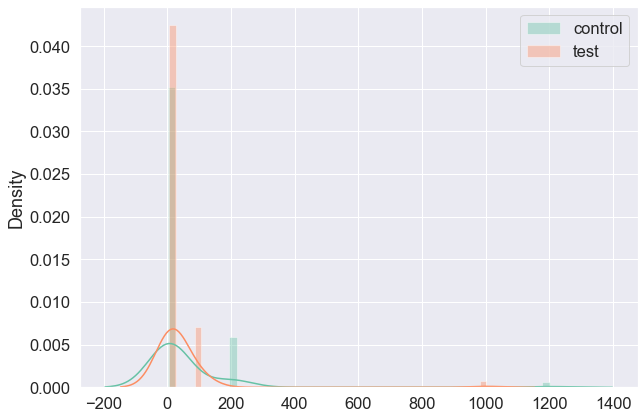

In [14]:
plt.figure(figsize=(10, 7))
sns.distplot(sample_control, label='control')
sns.distplot(sample_test, label='test')
plt.legend()

In [15]:
sps.ttest_ind(np.log(sample_control + 1), np.log(sample_test + 1), alternative='less')

Ttest_indResult(statistic=-2.4931552876266925, pvalue=0.006913156945485238)

In [16]:
sps.mannwhitneyu(sample_control, sample_test, alternative='less')

MannwhitneyuResult(statistic=1618.0, pvalue=0.0001165279789379951)

In [17]:
print(f"среднее в тесте: {np.mean(sample_test)}\n"
      f"среднее в контроле: {np.mean(sample_control)}")

среднее в тесте: 39.95303882845503
среднее в контроле: 50.71157326635097


In [18]:
sample_test    = [8] * 600 + [20] * 600 + [100] * 200 + [1000] * 20
sample_control = [3] * 600 + [10] * 600 + [200] * 200 + [1200] * 20
sample_control = np.array(sample_control) + sps.norm().rvs(len(sample_control))
sample_test    = np.array(sample_test) + sps.norm().rvs(len(sample_test))

In [19]:
sps.ttest_ind(sample_control, sample_test, alternative='greater')

Ttest_indResult(statistic=2.052890146013908, pvalue=0.020087363298462682)

## выкидывать топ 1% (или n%) в контроле и в тесте, чтобы избавиться от выбросов


**1 пример: использовать в тесте и в контроле разные оценки для квантилей**

AA-тест

In [21]:
# 2. Создание тестируемого критерия
def relative_ttest(control, test):
    mean_control = np.mean(control)
    var_mean_control  = np.var(control) / len(control)

    difference_mean = np.mean(test) - mean_control
    difference_mean_var  = np.var(test) / len(test) + var_mean_control
    
    covariance = -var_mean_control

    relative_mu = difference_mean / mean_control
    relative_var = difference_mean_var / (mean_control ** 2) \
                    + var_mean_control * ((difference_mean ** 2) / (mean_control ** 4))\
                    - 2 * (difference_mean / (mean_control ** 3)) * covariance
    relative_distribution = sps.norm(loc=relative_mu, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    effect = relative_mu
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)

In [22]:
# 3. Заводим счетчик
bad_cnt = 0

# 4. Цикл проверки
N = 30000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую AA - тест
    control = sps.expon(scale=1000).rvs(1000)
    test = sps.expon(scale=1000).rvs(1000)
    
    outlier_control_filter = np.quantile(control, 0.99)
    outlier_test_filter = np.quantile(test, 0.99)
    
    control = control[control < outlier_control_filter]
    test    = test[test < outlier_test_filter]

    # 4.b. Запускаю критерий
    _, _, _, left_bound, right_bound = relative_ttest(control, test)
    
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0 or right_bound < 0:
        bad_cnt += 1

# 5. Строю доверительный интервал для конверсии ошибок у критерия.
left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/30000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.0675; доверительный интервал: [0.0647, 0.0704]


**2 пример: использовать в тесте и в контроле одну и ту же оценку для квантилей**

AA тест

In [23]:
# 3. Заводим счетчик
bad_cnt = 0

# 4. Цикл проверки
N = 30000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую AA - тест
    control = sps.expon(scale=1000).rvs(1000)
    test = sps.expon(scale=1000).rvs(1000)
    
    outlier_filter = np.quantile(np.concatenate([control, test]), 0.99)
    
    control = control[control < outlier_filter]
    test    = test[test < outlier_filter]

    # 4.b. Запускаю критерий
    _, _, _, left_bound, right_bound = relative_ttest(control, test)
    
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0 or right_bound < 0:
        bad_cnt += 1

# 5. Строю доверительный интервал для конверсии ошибок у критерия.
left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/30000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.0494; доверительный интервал: [0.047, 0.0519]


AB тест

In [24]:
# 3. Заводим счетчик
bad_cnt = 0

# 4. Цикл проверки
N = 30000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую AB - тест
    control = sps.expon(scale=1000).rvs(1000)
    test = sps.expon(scale=1000).rvs(1000)
    test *= 1.5
    
    outlier_filter = np.quantile(np.concatenate([control, test]), 0.99)
    
    control = control[control < outlier_filter]
    test    = test[test < outlier_filter]

    # 4.b. Запускаю критерий
    _, _, _, left_bound, right_bound = relative_ttest(control, test)
    
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0.5 or right_bound < 0.5:
        bad_cnt += 1

# 5. Строю доверительный интервал для конверсии ошибок у критерия.
left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/30000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.3381; доверительный интервал: [0.3328, 0.3435]


## Выкинуть топ n% пользователей на пред экспериментальном периоде

AB - тест

In [25]:
# 3. Заводим счетчик
bad_cnt = 0

# 4. Цикл проверки
N = 30000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую AB - тест
    control_before = sps.expon(scale=1000).rvs(10000)
    test_before = sps.expon(scale=1000).rvs(10000)
    
    control = control_before + sps.norm(loc=0, scale=100).rvs(10000)
    test = test_before + sps.norm(loc=0, scale=100).rvs(10000)
    test *= 1.5
    
    outlier_filter = np.quantile(np.concatenate([control_before, test_before]), 0.99)


    control = control[control_before < outlier_filter]
    test = test[test_before < outlier_filter]

    # 4.b. Запускаю критерий
    _, _, _, left_bound, right_bound = relative_ttest(control, test)
    
    
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0.5 or right_bound < 0.5:
        bad_cnt += 1

# 5. Строю доверительный интервал для конверсии ошибок у критерия.
left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/30000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.05; доверительный интервал: [0.0476, 0.0525]


АА-тест

In [26]:
# 3. Заводим счетчик
bad_cnt = 0

# 4. Цикл проверки
N = 30000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую AA - тест
    control_before = sps.expon(scale=1000).rvs(10000)
    test_before = sps.expon(scale=1000).rvs(10000)
    
    control = control_before + sps.norm(loc=0, scale=100).rvs(10000)
    test = test_before + sps.norm(loc=0, scale=100).rvs(10000)
    
    outlier_filter = np.quantile(np.concatenate([control_before, test_before]), 0.99)

    control = control[control_before < outlier_filter]
    test = test[test_before < outlier_filter]

    # 4.b. Запускаю критерий
    _, _, _, left_bound, right_bound = relative_ttest(control, test)
    
    
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0 or right_bound < 0:
        bad_cnt += 1

# 5. Строю доверительный интервал для конверсии ошибок у критерия.
left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/30000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.0495; доверительный интервал: [0.0471, 0.052]
